## Importing and preparing data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
%matplotlib inline
tf.random.set_seed(42)

In [2]:
df1=pd.read_csv('mHealth_subject1.csv')
df2=pd.read_csv('mHealth_subject2.csv')
df3=pd.read_csv('mHealth_subject3.csv')
df4=pd.read_csv('mHealth_subject4.csv')
df5=pd.read_csv('mHealth_subject5.csv')
df6=pd.read_csv('mHealth_subject6.csv')
df7=pd.read_csv('mHealth_subject7.csv')
df8=pd.read_csv('mHealth_subject8.csv')
df9=pd.read_csv('mHealth_subject9.csv')
df10=pd.read_csv('mHealth_subject10.csv')
df1["subject"]=["subject1"]*len(df1)
df1=df1[:-1]
df2["subject"]=["subject2"]*len(df2)
df2=df2[:-1]
df3["subject"]=["subject3"]*len(df3)
df3=df3[:-1]
df4["subject"]=["subject4"]*len(df4)
df4=df4[:-1]
df5["subject"]=["subject5"]*len(df5)
df5=df5[:-1]
df6["subject"]=["subject6"]*len(df6)
df6=df6[:-1]
df7["subject"]=["subject7"]*len(df7)
df7=df7[:-1]
df8["subject"]=["subject8"]*len(df8)
df8=df8[:-1]
df9["subject"]=["subject9"]*len(df9)
df9=df9[:-1]
df10["subject"]=["subject10"]*len(df10)
df10=df10[:-1]
# Renaming acceleration and gyro columns
def renameAccelerationAndGyroColumns(df):
    df.rename(columns={
        'acceleration from the left-ankle sensor (X axis)':'alx',
        'acceleration from the left-ankle sensor (Y axis)':'aly',
        'acceleration from the left-ankle sensor (Z axis)':'alz',
        'gyro from the left-ankle sensor (X axis)':'glx',
        'gyro from the left-ankle sensor (Y axis)':'gly',
        'gyro from the left-ankle sensor (Z axis)':'glz',
        'acceleration from the right-lower-arm sensor (X axis)':'arx',
        'acceleration from the right-lower-arm sensor (Y axis)':'ary',
        'acceleration from the right-lower-arm sensor (Z axis)':'arz',
        'gyro from the right-lower-arm sensor (X axis)':'grx',
        'gyro from the right-lower-arm sensor (Y axis)':'gry',
        'gyro from the right-lower-arm sensor (Z axis)':'grz',
        'Label':'Activity'
    },inplace=True)
renameAccelerationAndGyroColumns(df1)
renameAccelerationAndGyroColumns(df2)
renameAccelerationAndGyroColumns(df3)
renameAccelerationAndGyroColumns(df4)
renameAccelerationAndGyroColumns(df5)
renameAccelerationAndGyroColumns(df6)
renameAccelerationAndGyroColumns(df7)
renameAccelerationAndGyroColumns(df8)
renameAccelerationAndGyroColumns(df9)
renameAccelerationAndGyroColumns(df10)
df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10],ignore_index=True)

In [3]:
from sklearn.utils import resample
df_majority=df[df.Activity==0]
df_minorities=df[df.Activity!=0]
df_majority_downsampled=resample(df_majority,n_samples=30000,random_state=42)
df=pd.concat([df_majority_downsampled,df_minorities])
df.Activity.value_counts()

1.0     30720
2.0     30720
3.0     30720
4.0     30720
9.0     30720
10.0    30720
11.0    30720
5.0     30720
0.0     30000
7.0     29441
8.0     29337
6.0     28315
12.0    10342
Name: Activity, dtype: int64

In [4]:
# Dropping features having data outside 98% confidence interval
df1=df.iloc[:,[5,6,7,8,9,10,14,15,16,17,18,19,23,24]]
for feature in df1.columns[:-2]:
    lower_range=np.quantile(df[feature],0.01)
    upper_range=np.quantile(df[feature],0.99)
    print(feature,'range:',lower_range,'to',upper_range)
    df1=df1.drop(df1[(df1[feature]>upper_range)|(df1[feature]<lower_range)].index,axis=0)
    print('shape',df1.shape)

alx range: -11.47312 to 19.233
shape (365733, 14)
aly range: -19.379 to 2.447871999999997
shape (360018, 14)
alz range: -18.95 to 14.19623999999999
shape (356270, 14)
glx range: -0.74212 to 0.80705
shape (349377, 14)
gly range: -1.0694 to 0.96623
shape (342841, 14)
glz range: -1.1061 to 0.82908
shape (337391, 14)
arx range: -21.492 to 9.097647999999998
shape (332307, 14)
ary range: -18.694 to 11.948059999999998
shape (326241, 14)
arz range: -10.367 to 11.823119999999996
shape (323674, 14)
grx range: -1.0196 to 0.95686
shape (320188, 14)
gry range: -1.1417 to 0.90965
shape (315352, 14)
grz range: -0.69828 to 1.125
shape (310929, 14)


In [5]:
label_map={
    0:'Nothing',
    1:'Standing still',  
    2:'Sitting and relaxing', 
    3:'Lying down',  
    4:'Walking',  
    5:'Climbing stairs',  
    6:'Waist bends forward',
    7:'Frontal elevation of arms', 
    8:'Knees bending (crouching)', 
    9:'Cycling', 
    10:'Jogging', 
    11:'Running', 
    12:'Jump front & back' 
}

## Modeling Data Preparation

In [6]:
#spliting data into train and test set
print(df1.shape)
train=df1[(df1['subject']!='subject10')&(df1['subject']!='subject9')]
test=df1.drop(train.index,axis=0)
train.shape,test.shape

(310929, 14)


((246501, 14), (64428, 14))

In [7]:
X_train=train.drop(['Activity','subject'],axis=1)
y_train=train['Activity']
X_test=test.drop(['Activity','subject'],axis=1)
y_test=test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((246501, 12), (246501,), (64428, 12), (64428,))

In [8]:
from scipy import stats
#function to create time series dataset for seuence modeling
def create_dataset(X,y,time_steps,step=1):
    Xs,ys=[],[]
    for i in range(0,len(X)-time_steps,step):
        x=X.iloc[i:(i+time_steps)].values
        labels=y.iloc[i:i+time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs),np.array(ys).reshape(-1,1)

In [9]:
X_train,y_train=create_dataset(X_train,y_train,100,step=50)
X_train.shape,y_train.shape

((4929, 100, 12), (4929, 1))

In [10]:
X_test,y_test=create_dataset(X_test,y_test,100,step=50)
X_test.shape,y_test.shape

((1287, 100, 12), (1287, 1))

## Model building

In [11]:
model=keras.Sequential()
model.add(layers.Input(shape=[100,12]))
model.add(layers.Conv1D(filters=32,kernel_size=3,padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64,kernel_size=3,padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.LSTM(64))
model.add(layers.Dense(units=128,activation='relu'))
model.add(layers.Dense(13,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           1184      
                                                                 
 batch_normalization (BatchN  (None, 100, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 100, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           6208      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 100, 64)           0

In [12]:
model1=keras.Sequential()
model1.add(layers.Input(shape=[100,12]))
model1.add(layers.Conv1D(filters=16,kernel_size=3,padding="same"))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.2))

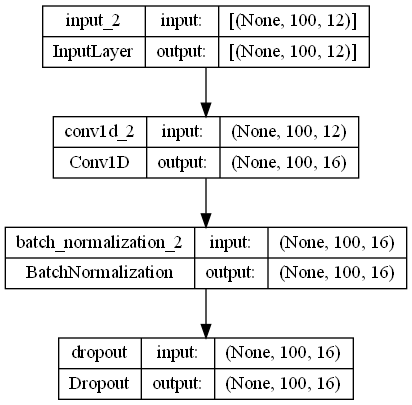

In [13]:
tf.keras.utils.plot_model(model1,show_shapes=True)

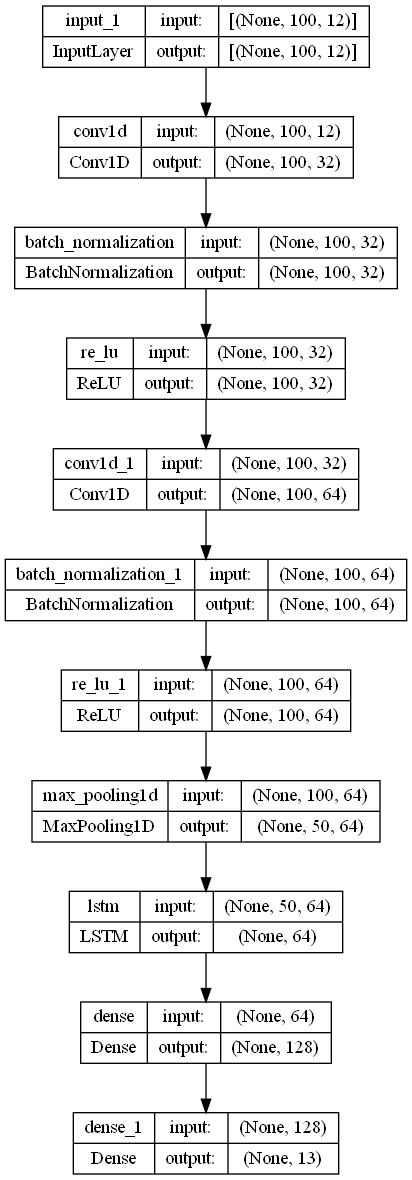

In [14]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [15]:
callbacks=[keras.callbacks.ModelCheckpoint("mhealth_best.h5",save_best_only=True,monitor="val_loss"),keras.callbacks.EarlyStopping(monitor="val_loss",patience=50,verbose=1)]
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"],)
model_history=model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/10
155/155 [==============================] - 7s 29ms/step - loss: 0.7638 - sparse_categorical_accuracy: 0.7716 - val_loss: 1.3566 - val_sparse_categorical_accuracy: 0.5633
Epoch 2/10
155/155 [==============================] - 4s 27ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.9454 - val_loss: 0.4644 - val_sparse_categorical_accuracy: 0.8788
Epoch 3/10
155/155 [==============================] - 5s 30ms/step - loss: 0.1797 - sparse_categorical_accuracy: 0.9462 - val_loss: 0.3163 - val_sparse_categorical_accuracy: 0.9068
Epoch 4/10
155/155 [==============================] - 4s 26ms/step - loss: 0.1002 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.1250 - val_sparse_categorical_accuracy: 0.9666
Epoch 5/10
155/155 [==============================] - 4s 25ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.2364 - val_sparse_categorical_accuracy: 0.9363
Epoch 6/10
155/155 [==============================] - 4s 26ms/step - loss: 0.1075 - sparse_cate

## Model Evaluation

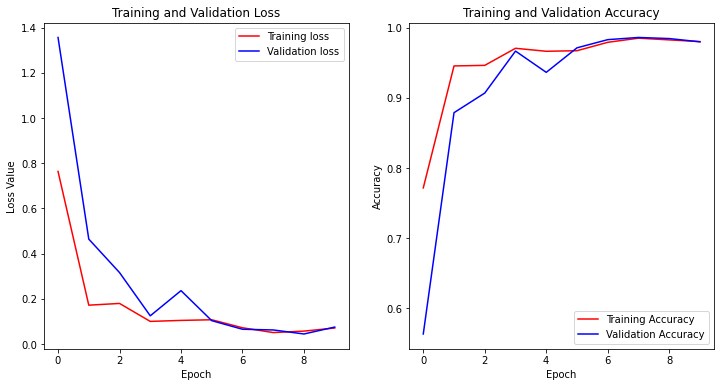

In [16]:
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_accuracy=model_history.history['sparse_categorical_accuracy']
val_accuracy=model_history.history['val_sparse_categorical_accuracy']
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,'r',label='Training loss')
plt.plot(val_loss,'b',label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accuracy,'r',label='Training Accuracy')
plt.plot(val_accuracy,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
model=keras.models.load_model('./mhealth_best.h5')
train_loss,train_acc=model.evaluate(X_train,y_train)
test_loss,test_acc=model.evaluate(X_test,y_test)
print("Train accuracy",round(train_acc*100,2),'%')
print("Train loss",train_loss)
print("Test accuracy",round(test_acc*100,2),'%')
print("Test loss",test_loss)

41/41 [==============================] - 0s 9ms/step - loss: 0.0446 - sparse_categorical_accuracy: 0.9845
Train accuracy 99.49 %
Train loss 0.01907520368695259
Test accuracy 98.45 %
Test loss 0.04461529850959778


In [18]:
pred=model.predict(X_test)
pred=np.argmax(pred,axis=1)
pred=pred.reshape(-1,1)

41/41 [==============================] - 1s 9ms/step


In [19]:
pred

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [12],
       [12],
       [12]], dtype=int64)

In [23]:
issues=[["""a. electrocardiogram signal : facing potential issues such as arrhythmias, which can lead to irregular heart rhythms, or underlying heart conditions that require medical evaluation. 
         b. magnetometer signal from the right-lower-arm (X-axis) : Sudden spikes in the magnetometer signal from the right-lower-arm (X-axis) may suggest potential health issues, including muscle disorders, neurological conditions, or involuntary muscle contractions. A medical evaluation is advisable to determine the underlying cause."""],
        ["""a. acceleration from the left-ankle sensor (Y axis) : Sudden spikes in acceleration from the left-ankle sensor (Y-axis) while sitting and relaxing might indicate potential health issues, including involuntary muscle movements, tremors, or neurological conditions. A medical evaluation is recommended to determine the underlying cause.
        b. magnetometer from the right-lower-arm sensor (Z axis) : Sudden spikes in the magnetometer signal from the right-lower-arm sensor (Z-axis) while sitting and relaxing may suggest potential health issues related to muscle twitches, spasms, or neurological disturbances, requiring medical assessment for diagnosis and intervention."""],
        ["""a. acceleration from the right-lower-arm sensor (Z axis) : Indicate potential health issues related to muscle spasms, tremors, or neurological conditions, requiring medical evaluation for diagnosis and treatment.
        b. electrocardiogram signal (lead 1) : An abnormal electrocardiogram (ECG or EKG) signal in lead I when lying down can indicate various health issues related to the electrical activity of the heart. Lead I records electrical signals that travel from the right arm to the left arm, so abnormalities in this lead can provide valuable information about cardiac health. Some of the potential health hazards include Myocardial Infarction (Heart Attack), inflammation of the pericardium (the sac surrounding the heart) and electrolyte Imbalances"""],
        ["""a. acceleration from the left ankle sensor (Z axis) : Abnormal sensor values for acceleration of the left ankle (Z-axis) when walking can be indicative of various symptoms and health issues related to gait and lower limb function, foot and/or joint problems, pain or discomfort and footwear issues, inflammation, etc.
        b. electrocardiogram signal (lead 2) : Abnormal ECG patterns during exercise can be a sign of reduced blood flow to the heart muscle, which may be due to coronary artery disease (CAD). This can lead to chest pain or angina during physical activity, valvular heart disease. Certain ECG patterns can suggest bundle branch block, which is an electrical conduction issue in the heart. It may lead to irregular heart rhythms and other heart problems."""],
        ["""electrocardiogram signal : Indicate cardiovascular stress or arrhythmias, warranting medical evaluation."""],
        ["""electrocardiogram signal : Indicate cardiovascular stress or arrhythmias, warranting medical evaluation."""],
        ["""a. magnetometer from the right-lower-arm sensor (Z axis) : Conditions like essential tremor, Parkinson's disease, or other movement disorders can cause abnormal arm movements and, in turn, affect magnetometer readings during arm elevation. Neuropathies, nerve compression syndromes, or other nerve disorders affecting the arm's function can result in abnormal sensor values during arm elevation.
        b. electrocardiogram signal (lead 2) : Indicate cardiovascular stress or arrhythmias, warranting medical evaluation."""],
        ["""electrocardiogram signal : Indicate cardiovascular stress or arrhythmias, warranting medical evaluation."""],
        ["""a. gyro from the right-lower-arm sensor (Y axis) : Abnormal gyro sensor readings can disrupt your ability to maintain balance and control while cycling. In response to unexpected balance challenges caused by sensor abnormalities, you may inadvertently tense or strain your muscles. This can lead to muscular discomfort, fatigue, or overuse injuries.
        b. gyro from the left-ankle sensor (Z axis) : health issues related to balance problems, coordination difficulties, or neurological disturbances, necessitating medical evaluation."""],
        ["""a. electrocardiogram signal (lead 1) : indicate cardiac stress or arrhythmias, necessitating medical evaluation.
        b. acceleration from the right-lower-arm sensor (Z axis) : Indicate potential health issues related to muscle spasms, tremors, or neurological conditions, requiring medical evaluation for diagnosis and treatment."""],
        ["""a. electrocardiogram signal (lead 1) : indicate cardiac stress or arrhythmias, necessitating medical evaluation.
        b. gyro from the right-lower-arm sensor (Y axis) : muscle tremors, balance problems, or neurological disturbances, warranting medical evaluation."""],
        ["""a. electrocardiogram signal (lead 1) : indicate cardiac stress or arrhythmias, necessitating medical evaluation.
        b. acceleration from the chest sensor (Z axis) : issues related to physical stress, muscular strain, or imbalance, necessitating medical evaluation."""]]

In [24]:
preventive_measures=[["""a. electrocardiogram signal : The person should consult a healthcare professional for a thorough cardiac evaluation and follow any recommended treatment or lifestyle changes to address the underlying issue. Maintaining a heart-healthy lifestyle with regular exercise and a balanced diet can also help.
                    b. magnetometer signal from the right-lower-arm (X-axis) : Consult a healthcare professional for evaluation and avoid exposure to strong magnetic fields."""],
                    ["""a. acceleration from the left-ankle sensor (Y axis) : If experiencing unexplained spikes in acceleration, seek a medical evaluation for diagnosis and guidance on appropriate precautions or treatments.
                    b. magnetometer from the right-lower-arm sensor (Z axis) : In case of unexplained spikes in the magnetometer signal, consult a healthcare professional for evaluation and follow their guidance for necessary precautions or treatments."""],
                    ["""a. acceleration from the right-lower-arm sensor (Z axis) : If experiencing unexplained spikes in acceleration, consult a healthcare professional for assessment and follow their recommendations for necessary precautions or interventions.
                    b. electrocardiogram signal (lead 1) : Preventing the health issues associated with abnormal electrocardiogram (ECG) signals when lying down often involves maintaining good heart health and addressing risk factors. Maintain a Healthy Lifestyle, manage stress, monitor blood pressure and manage cholestrol levels, limit alcohol and caffeine before bed and sleep well."""],
                    ["""a. acceleration from the left ankle sensor (Z axis) : Stay active and exercise, strengthen muscles, maintain a healthy weight, wear proper footwear, pay attention to walking posture, improve balance and fall prevention.
                    b. electrocardiogram signal (lead 2) : Regular Check-Ups, warm-up and cool down, stay hydrated and avoid excessive physical exertion (listen to your body and regular rest)."""],
                    ["""electrocardiogram signal : Before starting your ascent, perform a brief warm-up that includes light aerobic exercise like brisk walking or calf raises. Maintain Good Posture. Allow your arms to naturally swing in rhythm with your steps. Avoid rushing or taking overly large steps, which can lead to undue cardiovascular stress."""],
                    ["""electrocardiogram signal : Bend at the hips and knees, not at the waist, to reduce strain on your lower back and minimize the impact on your heart. A strong core can help support your spine and reduce the risk of back strain when bending forward."""],
                    ["""a. magnetometer from the right-lower-arm sensor (Z axis) : Address any underlying neuromuscular conditions through medical evaluation and appropriate treatment. Pay attention to the health of your arm and shoulder joints. Practice stress-reduction techniques, such as relaxation, deep breathing, meditation, or mindfulness, to manage psychological factors that may affect arm movements.
                    b. electrocardiogram signal (lead 2) : Be mindful of how you position your arms when raised. Avoid overextending or hyperextending your arms, which can strain your muscles and cardiovascular system. Do not hold your breath when raising your arms. Continue to breathe normally during the movement. If you are taking medications, adhere to your prescribed regimen and discuss potential side effects with your healthcare provider."""],
                    ["""electrocardiogram signal : Maintain good posture while crouching. Keep your back straight, shoulders relaxed, and knees aligned with your feet. Engage your leg muscles, particularly your quadriceps and hamstrings, to support your body weight when crouching. Avoid placing excessive strain on your lower back. Engage your core muscles to provide stability and protect your lower back when crouching. Distribute your body weight evenly between both legs while crouching to prevent undue stress on one side."""],
                    ["""a. gyro from the right-lower-arm sensor (Y axis) : Consult a healthcare professional for guidance and diagnosis if experiencing unexpected spikes in the gyro signal during activities like cycling.
                    b. gyro from the left-ankle sensor (Z axis) : Seek medical assessment for guidance and diagnosis."""],
                    ["""a. electrocardiogram signal (lead 1) : Seek medical evaluation for guidance and further cardiac assessment
                    b. acceleration from the right-lower-arm sensor (Z axis) : If experiencing unexplained spikes in acceleration, consult a healthcare professional for assessment and follow their recommendations for necessary precautions or interventions."""],
                    ["""a. electrocardiogram signal (lead 1) : Seek medical evaluation for guidance and further cardiac assessment
                    b. gyro from the right-lower-arm sensor (Y axis) : Consult a healthcare professional for guidance and diagnosis if experiencing unexpected spikes in the gyro signal."""],
                    ["""a. electrocardiogram signal (lead 1) : Seek medical evaluation for guidance and further cardiac assessment
                    b. acceleration from the chest sensor (Z axis) : Consult a healthcare professional for guidance and diagnosis."""]]

In [20]:
pred.shape,y_test.shape

((1287, 1), (1287, 1))

In [21]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,pred))
print('*'*50)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        92
         1.0       1.00      0.99      1.00       123
         2.0       0.99      0.99      0.99       123
         3.0       0.99      1.00      1.00       122
         4.0       0.99      0.99      0.99       120
         5.0       0.99      1.00      0.99        84
         6.0       0.90      0.99      0.94       106
         7.0       1.00      0.98      0.99       112
         8.0       0.98      0.90      0.94       116
         9.0       1.00      0.99      1.00       121
        10.0       0.98      1.00      0.99        89
        11.0       1.00      0.98      0.99        52
        12.0       1.00      1.00      1.00        27

    accuracy                           0.98      1287
   macro avg       0.99      0.99      0.99      1287
weighted avg       0.99      0.98      0.98      1287

**************************************************
[[ 92   0   0   0   0   0   

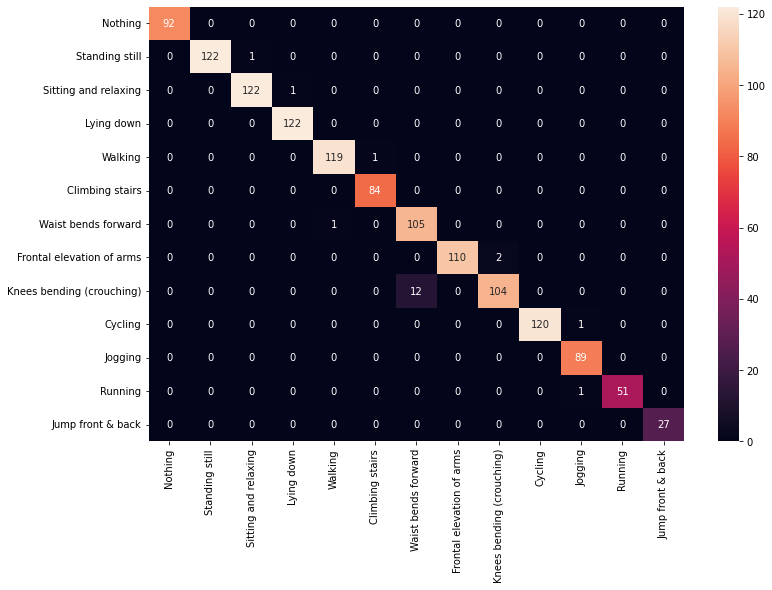

In [22]:
plt.figure(figsize=(12,8))
conf_matrix=confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix,xticklabels=label_map.values(),yticklabels=label_map.values(),annot=True,fmt="d")
plt.show()

Model performs really well on almost all activities but confuses between sitting and frontal arms elevation. This would be solved by doing feature engineering, that will be the future task.